# Recommendation Challenge

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import scipy.sparse as sparse

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split

import scipy.sparse as sparse

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import json
import category_encoders as ce
from sklearn.preprocessing import MultiLabelBinarizer
import re

C:\Users\trigu\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
train.head()

C:\Users\trigu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\trigu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,5.0,True,"03 1, 2016",B006F63M8U,Linda Odom,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0
2,5.0,True,"06 26, 2016",B00112O8NG,DesertBlossom,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,NaN,39495,5600,1.0
3,5.0,True,"09 5, 2013",B00MRAQUM8,Connie L. Reaves,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,NaN,NaN,NaN,72854,30249,1.0
4,5.0,True,"09 14, 2016",B000R7RN0G,Mike P.,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,NaN,{'Flavor:': ' Jalapeo'},NaN,74859,4349,1.0


In [4]:
with open('meta_Grocery_and_Gourmet_Food.json') as json_file:      
    meta = json_file.readlines()
    # this line below may take at least 8-10 minutes of processing for 4-5 million rows. It converts all strings in list to actual json objects. 
    meta = list(map(json.loads, meta)) 

meta = pd.DataFrame(meta)
meta.head()

,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
0,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs,...","[BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS, Stat...",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Ariola Imports,"165,181inGroceryGourmetFood(","[B0000D9MYM, B0000D9MYL, B00ADHIGBA, B00H9OX59...",Grocery,$41.91,0681727810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[Grocery & Gourmet Food, Cooking & Baking, Sug...","[Shipped from UK, please allow 10 to 21 busine...",Trim Healthy Mama Xylitol,NaN,"315,867inGroceryGourmetFood(",NaN,Grocery,NaN,0853347867,"[B01898YHXK, B01BCM6LAC, B00Q4OL47O, B00Q4OL5Q...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN
2,"[Grocery & Gourmet Food, Cooking & Baking, Fro...",[Jazz up your cakes with a sparkling monogram ...,Letter C - Swarovski Crystal Monogram Wedding ...,Unik Occasions,">#669,941 in Kitchen & Dining (See Top 100 in ...",[B07DXN65TF],Amazon Home,$29.95,1888861118,NaN,NaN,"September 21, 2010",NaN,NaN,NaN,NaN,NaN
3,"[Grocery & Gourmet Food, Cooking & Baking, Fro...","[Large Letter - Height 4.75""]",Letter H - Swarovski Crystal Monogram Wedding ...,Other,">#832,581 in Kitchen & Dining (See Top 100 in ...",NaN,Amazon Home,$11.45,1888861517,NaN,NaN,"September 11, 2011","[Large Letter - Height 4.75""]",NaN,NaN,NaN,NaN
4,"[Grocery & Gourmet Food, Cooking & Baking, Fro...","[4.75""]",Letter S - Swarovski Crystal Monogram Wedding ...,Unik Occasions,">#590,999 in Kitchen & Dining (See Top 100 in ...",NaN,Amazon Home,$15.00,1888861614,NaN,NaN,"September 11, 2011","[4.75"" height]",NaN,NaN,NaN,NaN


### EDA

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857895 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         857895 non-null  float64
 1   verified        857895 non-null  bool   
 2   reviewTime      857895 non-null  object 
 3   asin            857895 non-null  object 
 4   reviewerName    857719 non-null  object 
 5   reviewText      857616 non-null  object 
 6   summary         857725 non-null  object 
 7   unixReviewTime  857895 non-null  int64  
 8   vote            118740 non-null  object 
 9   style           444406 non-null  object 
 10  image           7142 non-null    object 
 11  userid          857895 non-null  int64  
 12  itemid          857895 non-null  int64  
 13  rating          857895 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 85.9+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285965 entries, 0 to 285964
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   verified        285965 non-null  bool  
 1   reviewTime      285965 non-null  object
 2   asin            285965 non-null  object
 3   reviewerName    285918 non-null  object
 4   unixReviewTime  285965 non-null  int64 
 5   vote            39462 non-null   object
 6   style           147680 non-null  object
 7   image           2368 non-null    object
 8   userid          285965 non-null  int64 
 9   itemid          285965 non-null  int64 
 10  Id              285965 non-null  int64 
dtypes: bool(1), int64(4), object(6)
memory usage: 22.1+ MB


We will drop excess elements from Train dataFrame:

In [7]:
to_drop = []
for col in train.columns:
    if  col not in test.columns:
        to_drop.append(col)
to_drop 

['overall', 'reviewText', 'summary', 'rating']

In [8]:
train = train.drop(['overall', 'reviewText', 'summary'], axis = 1)
train.head(3)

,verified,reviewTime,asin,reviewerName,unixReviewTime,vote,style,image,userid,itemid,rating
0,True,"10 4, 2016",B01CPNIEQG,Heather,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,True,"03 1, 2016",B006F63M8U,Linda Odom,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0
2,True,"06 26, 2016",B00112O8NG,DesertBlossom,1466899200,28,NaN,NaN,39495,5600,1.0


In [9]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287209 entries, 0 to 287208
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   category      287209 non-null  object
 1   description   251802 non-null  object
 2   title         287205 non-null  object
 3   brand         275787 non-null  object
 4   rank          275494 non-null  object
 5   also_view     121012 non-null  object
 6   main_cat      285716 non-null  object
 7   price         132136 non-null  object
 8   asin          287209 non-null  object
 9   also_buy      83332 non-null   object
 10  image         150214 non-null  object
 11  date          9663 non-null    object
 12  feature       16374 non-null   object
 13  details       273323 non-null  object
 14  similar_item  256 non-null     object
 15  tech1         744 non-null     object
 16  fit           4 non-null       object
dtypes: object(17)
memory usage: 37.3+ MB


Let's merge DataFrames by a common column 'asin'

In [10]:
data = pd.merge(meta,train, on='asin')
test = pd.merge(meta,test, on='asin')
data.head()

,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,...,verified,reviewTime,reviewerName,unixReviewTime,vote,style,image_y,userid,itemid,rating
0,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",[Lipton Yellow Label Tea use only the finest t...,Lipton Yellow Label Tea (loose tea) - 450g,Lipton,"30,937inGroceryGourmetFood(","[B00CREXSHY, B001QTRGAQ, B000JSQK70, B002EYZM4...",Grocery,$12.46,4639725043,"[B00886E4K0, B00CREXSHY, B001QTRGAQ, B002EYZM4...",...,True,"02 11, 2016",ALFRED W,1455148800,NaN,NaN,NaN,20,1,1.0
1,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",[Lipton Yellow Label Tea use only the finest t...,Lipton Yellow Label Tea (loose tea) - 450g,Lipton,"30,937inGroceryGourmetFood(","[B00CREXSHY, B001QTRGAQ, B000JSQK70, B002EYZM4...",Grocery,$12.46,4639725043,"[B00886E4K0, B00CREXSHY, B001QTRGAQ, B002EYZM4...",...,True,"08 28, 2016",cowgirl,1472342400,NaN,NaN,NaN,17,1,1.0
2,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",[Lipton Yellow Label Tea use only the finest t...,Lipton Yellow Label Tea (loose tea) - 450g,Lipton,"30,937inGroceryGourmetFood(","[B00CREXSHY, B001QTRGAQ, B000JSQK70, B002EYZM4...",Grocery,$12.46,4639725043,"[B00886E4K0, B00CREXSHY, B001QTRGAQ, B002EYZM4...",...,True,"07 4, 2015",Mohammed Siddiqui,1435968000,NaN,NaN,NaN,24,1,1.0
3,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",[Lipton Yellow Label Tea use only the finest t...,Lipton Yellow Label Tea (loose tea) - 450g,Lipton,"30,937inGroceryGourmetFood(","[B00CREXSHY, B001QTRGAQ, B000JSQK70, B002EYZM4...",Grocery,$12.46,4639725043,"[B00886E4K0, B00CREXSHY, B001QTRGAQ, B002EYZM4...",...,True,"08 3, 2013",Karen Amrhein,1375488000,NaN,NaN,NaN,34,1,1.0
4,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",[Lipton Yellow Label Tea use only the finest t...,Lipton Yellow Label Tea (loose tea) - 450g,Lipton,"30,937inGroceryGourmetFood(","[B00CREXSHY, B001QTRGAQ, B000JSQK70, B002EYZM4...",Grocery,$12.46,4639725043,"[B00886E4K0, B00CREXSHY, B001QTRGAQ, B002EYZM4...",...,True,"04 14, 2014",J. Voelkle,1397433600,NaN,NaN,NaN,32,1,1.0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 876561 entries, 0 to 876560
Data columns (total 27 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   category        876561 non-null  object 
 1   description     803859 non-null  object 
 2   title           876561 non-null  object 
 3   brand           870281 non-null  object 
 4   rank            839158 non-null  object 
 5   also_view       487527 non-null  object 
 6   main_cat        875596 non-null  object 
 7   price           608169 non-null  object 
 8   asin            876561 non-null  object 
 9   also_buy        752810 non-null  object 
 10  image_x         781854 non-null  object 
 11  date            12909 non-null   object 
 12  feature         147926 non-null  object 
 13  details         861055 non-null  object 
 14  similar_item    1194 non-null    object 
 15  tech1           4609 non-null    object 
 16  fit             0 non-null       object 
 17  verified  

###  Column Information

overall - the rating given by the user 
verified - whether the review has been verified
reviewTime - when was the review written
reviewerName - username
reviewText - review text
summary - concise review
vote - number of votes for a review
style - metadata
image - product picture
userid - user id
itemid - item id
id - id for prediction

### Let's check whether we have some None data:

In [12]:
data.isnull().sum()

category               0
description        72702
title                  0
brand               6280
rank               37403
also_view         389034
main_cat             965
price             268392
asin                   0
also_buy          123751
image_x            94707
date              863652
feature           728635
details            15506
similar_item      875367
tech1             871952
fit               876561
verified               0
reviewTime             0
reviewerName         180
unixReviewTime         0
vote              754951
style             421069
image_y           869307
userid                 0
itemid                 0
rating                 0
dtype: int64

There are a lot of columns that don't have any relevant values. Let's drop them

In [13]:
data = data.drop(['date', 'feature', 'similar_item', 'tech1', 'fit'], axis = 1)


### Feature Processing

 Let's think about how we better fill the gaps in the following columns and prepare them for training models

#####  'brand'

In [14]:
data.brand.describe()

count     870281
unique      8866
top         KIND
freq       22714
Name: brand, dtype: object

As we see the brand feature is categorical and there is a huge number of values for this column. In order to encode them, we use Target Encoding.
For the case of categorical target: features are replaced with a blend of posterior probability of the target given particular categorical value and the prior probability of the target over all the training data.

In [15]:
data.brand.value_counts()

KIND                     22714
Bob's Red Mill           14189
Twinings                 11214
Planters                 10740
Frontier                  7415
                         ...  
Genesis Today                1
Sugar                        1
Drumstick                    1
Global Healing Center        1
Brooks                       1
Name: brand, Length: 8866, dtype: int64

In [16]:
brand_encoder = ce.TargetEncoder()
brand_encoder.set_params(smoothing = 10)
data['Brand Encoded'] = brand_encoder.fit_transform(data['brand'], data['rating'])

C:\Users\trigu\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [17]:
test['Brand Encoded'] = brand_encoder.transform(test['brand'], y=None, override_return_df=False)

In [18]:
data['Brand Encoded'].isnull().sum()

0

Target Encoding saves our efforts and handles gaps by itself, so we can simply delete the old column 'brand'

In [19]:
data = data.drop(['brand'], axis = 1)
test = test.drop(['brand'], axis = 1)

#### 'title'

In [20]:
data.title.describe()

count                                                876561
unique                                                41149
top       KIND Bars, Dark Chocolate Nuts & Sea Salt, Glu...
freq                                                   7496
Name: title, dtype: object

In [21]:
title_encoder = ce.TargetEncoder()
#main_cat_encoder.set_params(smoothing = 10)
data['Title Encoded'] = title_encoder.fit_transform(data['title'], data['rating'])
test['Title  Encoded'] = title_encoder.transform(test['title'], y=None, override_return_df=False)

C:\Users\trigu\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [22]:
data = data.drop(['title'], axis = 1)
test = test.drop(['title'], axis = 1)

In [23]:
data['Title Encoded']

0         0.761905
1         0.761905
2         0.761905
3         0.761905
4         0.761905
            ...   
876556    0.800888
876557    0.800888
876558    0.800888
876559    0.800888
876560    0.800888
Name: Title Encoded, Length: 876561, dtype: float64

#### 'main_cat'

In [24]:
data.main_cat.describe()

count      875596
unique         17
top       Grocery
freq       828155
Name: main_cat, dtype: object

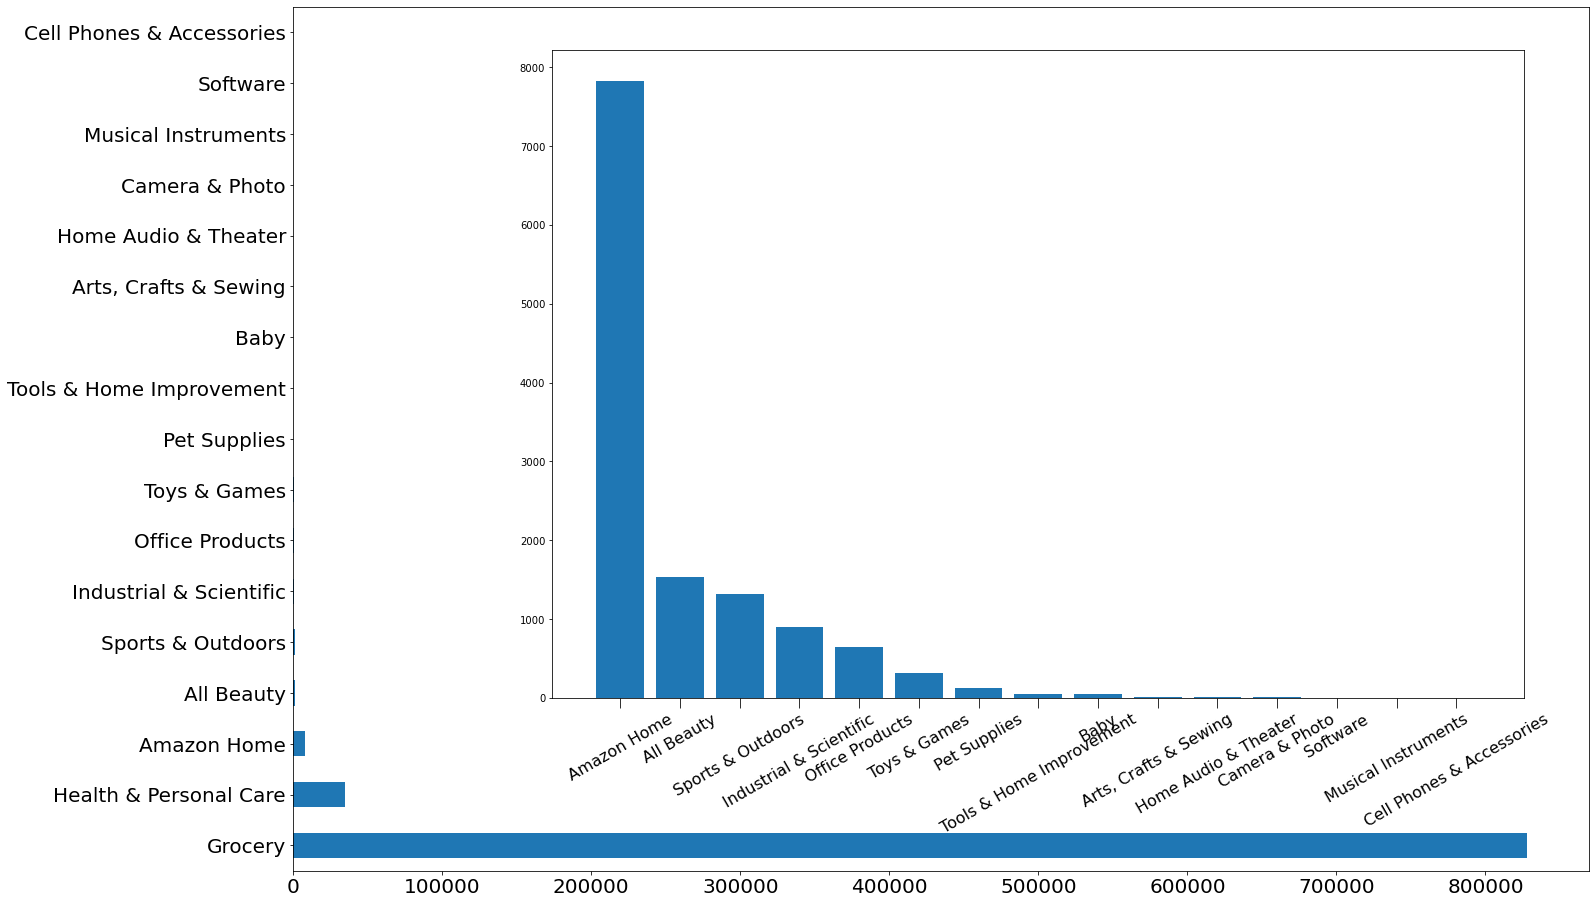

In [25]:

fig = plt.figure(figsize =(18,12))
main_axes = fig.add_axes([0, 0, 1, 1])
main_axes.bar( data.main_cat.value_counts().values, data.main_cat.value_counts().index )
data.main_cat.value_counts().plot.barh( )
insert_axes = fig.add_axes([0.2, 0.2, 0.75, 0.75])
insert_axes.bar( data.main_cat[(data.main_cat != 'Grocery') & (data.main_cat != 'Health & Personal Care')].value_counts().index, data.main_cat[(data.main_cat != 'Grocery') & (data.main_cat != 'Health & Personal Care')].value_counts().values )

main_axes.tick_params(axis='both', which='major', labelsize=20)
insert_axes.tick_params(axis="x", which='major', size = 10, labelsize=16, rotation = 30)


In [26]:
main_cat_encoder = ce.TargetEncoder()
#main_cat_encoder.set_params(smoothing = 10)
data['Main Cat Encoded'] = main_cat_encoder.fit_transform(data['main_cat'], data['rating'])
test['Main Cat Encoded'] = main_cat_encoder.transform(test['main_cat'], y=None, override_return_df=False)

C:\Users\trigu\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [27]:
data = data.drop(['main_cat'], axis = 1)
test = test.drop(['main_cat'], axis = 1)

#### 'rank'

Let's separate numeric values from columns using regular expressions

In [28]:
data['rank'].describe()

count                      839158
unique                      36878
top       18inGroceryGourmetFood(
freq                         7482
Name: rank, dtype: object

Let's separate numeric values from columns using regular expressions

In [29]:
def rank_parce(x):
    try:
        return float((re.search(r'^\d*', x)).group(0))
    except:
        x
data['rank'] = data['rank'].apply(rank_parce)
data['rank'] = data['rank'].fillna(0)

#### 'image_x'

In [30]:
def image_x_bin(x):
    try:
        return 1
    except: 0

In [31]:
data['image_x'] = data['image_x'].apply(image_x_bin)
data['image_x']

0         1
1         1
2         1
3         1
4         1
         ..
876556    1
876557    1
876558    1
876559    1
876560    1
Name: image_x, Length: 876561, dtype: int64

##### 'category'

data['category'].head(3)

This column is tricky enough, to invest a little more time in it. 

categories = set() #Set fot all categories
for s in  data['category']:
    categories = categories.union(set(s))
      

Let's see how often different categories are found and how many categories are listed.

categories_dict= dict.fromkeys(categories, 0)
max_len = 0
for c in data['category']:
    if len(c) > max_len:
        max_len = len(c)
    for el in c:
        if el in categories:
            categories_dict[el]+=1
print('Maximal length of list:', max_len)
categories_df = pd.DataFrame.from_dict(categories_dict, orient='index')
categories_df[0].sort_values(ascending = False)

            

Each individual category is repeated often enough and is important information for our predictions . To process and encode them, we will create a temporary dataframe

data['category_string'] =  data['category'].to_string()
data['category_string']

category_encoder = ce.TargetEncoder()
#category_encoder.set_params(smoothing = 10)
data['Category Encoded'] = category_encoder.fit_transform(data['category_string'], data['rating'])

categories_df['cat_n'] = categories_df%max_len

categories_df = pd.Series(categories_df['cat_n'])

categories_df

def data_ask(x):
    x1 = x.apply(lambda x: None if str(x).strip() == '' else x)
    print(x1.astype(str).value_counts())
    x1.astype(str).value_counts().plot(kind='bar')
    return x1

def data_corr(b, repl):
    b1=b.fillna(repl)
    print(b1.astype(str).value_counts())
    b1.astype(str).value_counts().plot(kind='bar')
    return  b1


fam_sit.Pstatus=data_ask(fam_sit.Pstatus)

df_temp = data.loc[:, ('category', 'rating')]
for i in range(max_len):
    df_temp[i] = None
df_temp.head(3)

df_temp[0] = 0
df_temp[1] = 1
df_temp[2] = 2
df_temp[3] = 3
df_temp[4] = 4
df_temp

def parse_lists(row):
    for br in row['category']:
        i = categories_df[br]
        df[i] = br
    return row 



    
       
      
        
#data['numberOfDoors']=data.apply(lambda row:  doors(row), axis=1 )        

df_temp = df_temp.category.apply()

df_temp

def get_number(cat_list):
    numered = list(map((lambda x: [x, categories_df.loc[x]['cat_n']]),  cat_list))
    return numered

for i, cat_list in enumerate(df_temp['category']):
    numered = get_number(cat_list)
    for j in numered:
        df_temp.iloc[i][j[1]] = j[0]
        

 
        
        
    

'''
#With MultiLabelBinarizer you can transform between iterable of iterables and a multilabel format.
categories_df = data[['category', 'rating']]
mlb = MultiLabelBinarizer(sparse_output=True)
categories_df = categories_df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(categories_df.pop('category')),
                index=categories_df.index,
                columns=mlb.classes_))
                '''

#### 'price'

In [33]:
data['price']

0         $12.46
1         $12.46
2         $12.46
3         $12.46
4         $12.46
           ...  
876556    $10.95
876557    $10.95
876558    $10.95
876559    $10.95
876560    $10.95
Name: price, Length: 876561, dtype: object

Let's convert the price column to a numeric form. To do this, we will create a function that will try to convert values and collect in a separate list exceptions: those values that differ from the initially visible format

In [34]:
price_exceptions = []

def price_convert(x):
    try:
        return float(str(x).replace('$', '').strip())
    except:
        price_exceptions.append(x)
        return x

data['price'] = data['price'].apply(price_convert)

In [35]:
data['price']

0         12.46
1         12.46
2         12.46
3         12.46
4         12.46
          ...  
876556    10.95
876557    10.95
876558    10.95
876559    10.95
876560    10.95
Name: price, Length: 876561, dtype: object

In [36]:
print('We have ', len(price_exceptions), 'exceptions:')
price_exceptions

We have  4067 exceptions:


['$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',
 '$9.97 - $137.08',


In [37]:
def price_convert_exceptions(x):
    try:
        x_list = str(x).replace('$', '').strip().split('-')
        return float(x_list[0])+float(x_list[1])/len(x_list)
    except:
        return x

In [38]:
data['price'] = data['price'].apply(price_convert_exceptions)

In [39]:
data['price']

0         12.46
1         12.46
2         12.46
3         12.46
4         12.46
          ...  
876556    10.95
876557    10.95
876558    10.95
876559    10.95
876560    10.95
Name: price, Length: 876561, dtype: float64

In [40]:
data['price'] = data['price'].fillna(0)

{'whiskers': [<matplotlib.lines.Line2D at 0x11b409787c0>,
 'caps': [<matplotlib.lines.Line2D at 0x11b40978e80>,
 'boxes': [<matplotlib.lines.Line2D at 0x11b409784f0>],
 'medians': [<matplotlib.lines.Line2D at 0x11c4fe73580>],
 'fliers': [<matplotlib.lines.Line2D at 0x11c4fe738e0>],
 'means': []}

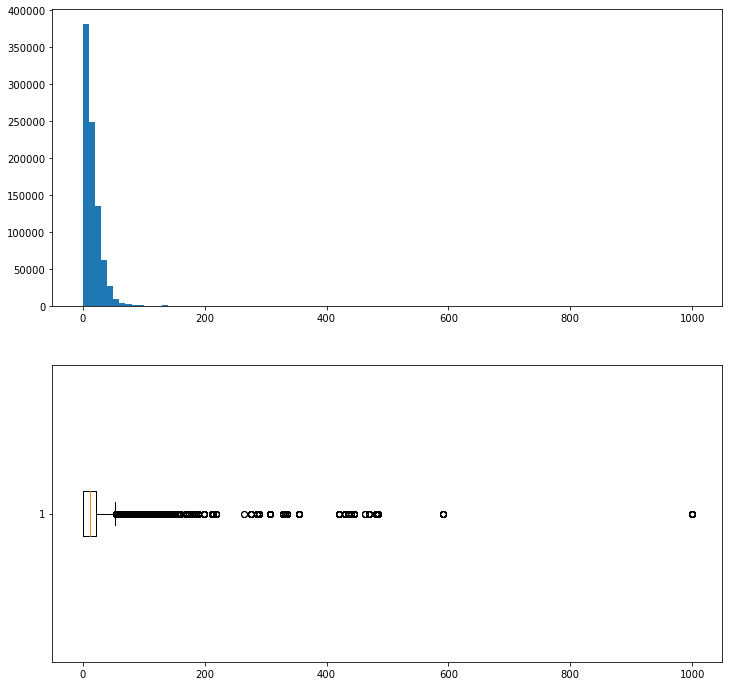

In [41]:
fig, axes=plt.subplots(2, 1 , figsize=(12,12))
axes[0].hist(data['price'], bins=100)
axes[1].boxplot(x = data['price'], vert =False)

In [42]:
data.price

0         12.46
1         12.46
2         12.46
3         12.46
4         12.46
          ...  
876556    10.95
876557    10.95
876558    10.95
876559    10.95
876560    10.95
Name: price, Length: 876561, dtype: float64

As we see, there are no gaps in the  userid, itemid and rating columns. We need to look at the distribution of the number of votes. That is, how many votes are given most often by users for different products and how many votes the product receives on average.

In [44]:
user_grouped = data.groupby('userid')['itemid'].count().sort_values()
item_grouped = data.groupby('itemid')['userid'].count().sort_values()

Text(0.5, 1.0, 'Logarithm of amounts of votes that have items')

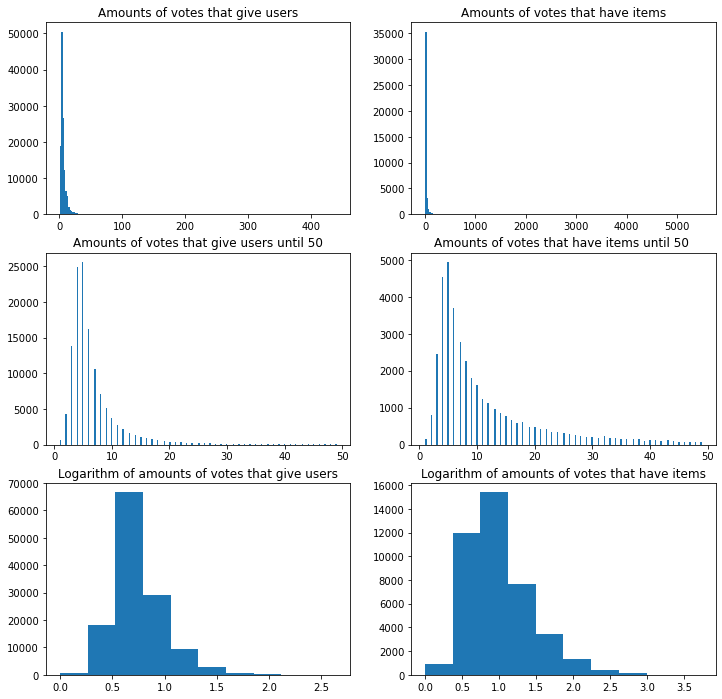

In [45]:
fig, axes=plt.subplots(3, 2 , figsize=(12,12))

axes[0,0].hist(user_grouped, bins=200)
axes[0,0].set_title('Amounts of votes that give users')

axes[0,1].hist(item_grouped, bins=200)
axes[0,1].set_title('Amounts of votes that have items')

axes[1,0].hist(user_grouped[user_grouped.values<50], bins=200)
axes[1,0].set_title('Amounts of votes that give users until 50')

axes[1,1].hist(item_grouped[item_grouped.values<50], bins=200)
axes[1,1].set_title('Amounts of votes that have items until 50 ')



axes[2,0].hist(np.log10(user_grouped.values))
axes[2,0].set_title('Logarithm of amounts of votes that give users')

axes[2,1].hist(np.log10(item_grouped.values))
axes[2,1].set_title('Logarithm of amounts of votes that have items')



Based on these graphs, we see that the data has a lot of users who gave only a very small number of votes for products, and products for which very few users voted. For them, the Collaborative model will be not effective enough.

### Splitting the data into training and test

In [46]:
train_data, test_data = train_test_split(data,random_state=32, shuffle=True)

In [47]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))

In [48]:
NUM_THREADS = 4 #число потоков
NUM_COMPONENTS = 30 #число параметров вектора 
NUM_EPOCHS = [20] #число эпох обучения
LR =[0.05]
epoch_dict = {}

for n_ep in NUM_EPOCHS:
    for lr in LR:

        model_LightFM_00 = LightFM(learning_rate=lr, loss='logistic',
                no_components=NUM_COMPONENTS)
        model_LightFM_00 = model_LightFM_00.fit(ratings_coo, epochs=n_ep, 
                  num_threads=NUM_THREADS)
        preds_00 = model_LightFM_00.predict(test_data.userid.values,
                      test_data.itemid.values)
        roc_auc_score = sklearn.metrics.roc_auc_score(test_data.rating, preds_00)
    
        epoch_dict['Epoche:' , n_ep, 'Learning Rate:' , lr] = roc_auc_score
    
    


In [ ]:
epoch_dict

In [ ]:
epoch_dict

In [ ]:
epoch_dict

In [49]:
preds_00 = model_LightFM_00.predict(test_data.userid.values,
                      test_data.itemid.values)


In [52]:
roc_auc_score = sklearn.metrics.roc_auc_score(test_data.rating, preds_00)
roc_auc_score

0.745890534279949

#GridSearchCV не работает
param_grid = {
    #'epochs': [20,30, 50, 100],
    'learning_rate' : [0.01, 0.05, 0.1, 0.2]
}

model_LightFM_GridSearch = GridSearchCV(estimator = LightFM(), scoring = 'roc_auc', param_grid = param_grid, n_jobs = 6)
model_LightFM_GridSearch = model_LightFM_GridSearch.fit(train_data[['userid', 'itemid']].values, train_data.rating)
                    
print(model_LightFM_GridSearch.best_params_)

# A hybrid latent representation recommender model

item_embeddings contains the estimated latent vectors for item features. 
user_embeddings contains the estimated latent vectors for user features.

https://making.lyst.com/lightfm/docs/examples/hybrid_crossvalidated.html#a-hybrid-model

In [ ]:
data.info()

In [70]:
item_features = []
for i, it in enumerate(data['itemid']):
    item_fe = []
    for fe in ['rank', 'price', 'image_x', 'Brand Encoded', 'Title Encoded', 'Main Cat Encoded']:
        item_fe.append(data.iloc[i][fe])
    item_tuple = (it, item_fe)
    item_features.append(item_tuple)
item_features = sparse.csr_matrix(item_features)
    

C:\Users\trigu\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


TypeError: no supported conversion for types: (dtype('O'),)

In [67]:
#item_features = sparse.coo_matrix(item_features)

In [65]:
a = sparse.coo_matrix(a)

In [68]:
model = LightFM(loss='warp',
               # item_alpha=ITEM_ALPHA,
                no_components=NUM_COMPONENTS)

# Fit the hybrid model. Note that this time, we pass
# in the item features matrix.
model = model.fit(
    ratings_coo,
    item_features=item_features,# (np.float32 csr_matrix of shape [n_items, n_item_features], optional) – Each row contains that item’s weights over features.
    epochs=NUM_EPOCHS,
    num_threads=NUM_THREADS)

TypeError: no supported conversion for types: (dtype('O'),)

In [ ]:
a = 5
